# Zero-shot reference mapping tutorial with scGPT

## Import scGPT and dependencies

In [1]:
from pathlib import Path
import numpy as np
from scipy.stats import mode
import scanpy as sc
import warnings
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import confusion_matrix
import seaborn as sns
import pandas as pd
import sys

sys.path.insert(0, "../")

import scgpt as scg

warnings.filterwarnings("ignore", category=ResourceWarning)

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Load the dataset, you may download the dataset from [here](https://drive.google.com/drive/folders/1jSPoPunGQOmd71vDsK0FS7UvmDhGdhQS?usp=sharing). We set the columns storing gene name columns, batch key and cell type key.

In [2]:
import anndata as ad

model_dir = Path("../../save/scGPT_human")
#adata = sc.read_h5ad('../../data/covid/batch_covid_subsampled_train.h5ad')
ada = sc.read_h5ad('../../data/readySeu_hrpi_GOOD.h5ad')
#test_adata = sc.read_h5ad('../../data/covid/batch_covid_subsampled_test.h5ad')
adata = ad.AnnData(
    X=ada.X.copy(),
    obs=ada.obs.copy(),
    var=ada.var.copy()
)

cell_type_key = "cluster"
gene_col = "names"

In [3]:
mapa = pd.read_csv('../../data/gene_info.csv',index_col=0)
mapa = mapa.set_index('feature_id')

def f(x):
    try:
        return mapa.loc[x]['feature_name']
    except:
        return -1
        
adata.var['names'] = adata.var.name.apply(lambda x: f(x))
adata = adata[:,adata.var.names!=-1]

#adata.var = adata.var.set_index('names')

adata.X = adata.X.toarray()

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


In [4]:
OKSM = ['SOX2', 'KLF4', 'POU5F1', 'MYC', 'NANOG']

TFs = pd.read_csv('../../../perturb_train/little_data/TF_db.csv', index_col = 0)
TFs = TFs.loc[:,'HGNC symbol'].tolist()

ipsc_genes = adata.var.names.tolist()
to_perturb = list(set(ipsc_genes).intersection(set(TFs)))

tf_exp = adata[:, adata.var.names.isin(to_perturb)].X

a = (tf_exp.shape[0] - (tf_exp==0).sum(axis=0))/tf_exp.shape[0]
threshold = 0.10  # Set your desired threshold here

# Get the indexes where values are above the threshold
to_perturb = np.array(to_perturb)[np.array(a).squeeze() > threshold]
to_perturb = np.array(list(set(list(to_perturb) + OKSM)))

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/IPython/core/interactiveshell.py:3577: SparseEfficiencyWarning: Comparing a sparse matrix with 0 using == is inefficient, try using != instead.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [5]:
len(to_perturb)

1306

In [6]:
from scgpt.preprocess import Preprocessor
# Preprocess the data following the scGPT data pre-processing pipeline
preprocessor = Preprocessor(
    use_key="X",  # the key in adata.layers to use as raw data
    filter_gene_by_counts=1,  # step 1
    filter_cell_by_counts=False,  # step 2
    normalize_total=1e4,  # 3. whether to normalize the raw data and to what sum
    result_normed_key="X_normed",  # the key in adata.layers to store the normalized data
    log1p=True,  # 4. whether to log1p the normalized data
    result_log1p_key="X_log1p",
    subset_hvg=False,  # 5. whether to subset the raw data to highly variable genes
    hvg_flavor="seurat_v3",
    binning=51,  # 6. whether to bin the raw data and to what number of bins
    result_binned_key="X",  # the key in adata.layers to store the binned data
)
#preprocessor(adata)
#adata.X = adata.layers['X']

In [8]:
sc.pp.highly_variable_genes(adata, n_top_genes=2000, subset=False)

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/scanpy/preprocessing/_highly_variable_genes.py:696: ImplicitModificationWarning: Trying to modify attribute `._uns` of view, initializing view as actual.
  adata.uns["hvg"] = {"flavor": flavor}


In [10]:
adata.var.loc[adata.var.names.isin(OKSM),'highly_variable'] = True

In [11]:
adata.var.loc[adata.var.names.isin(OKSM)]

,name,names,highly_variable,means,dispersions,dispersions_norm
ENSG00000111704,ENSG00000111704,NANOG,True,0.271937,0.886901,-0.440968
ENSG00000136826,ENSG00000136826,KLF4,True,0.091375,0.869556,-0.481919
ENSG00000136997,ENSG00000136997,MYC,True,0.120604,1.032706,-0.096731
ENSG00000181449,ENSG00000181449,SOX2,True,0.109746,0.854574,-0.517291
ENSG00000204531,ENSG00000204531,POU5F1,True,0.764697,1.444211,0.336494


In [12]:
adata.X = adata.X.toarray()

In [13]:
adata.obsm = dict()

In [14]:
#adata = adata[:,adata.var.names.isin(to_perturb)]

In [16]:
ref_embed_adata = scg.tasks.embed_data(
    adata,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=True
)

scGPT - INFO - match 17315/17315 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 685/685 [00:44<00:00, 15.26it/s]
/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [23]:
adata_fm0 = adata[adata.obs.library=='D0-fm',:].copy()

In [18]:
adata.obsm['X_scGPT'] = ref_embed_adata.X

In [24]:
#adata_fm0.X = adata_fm0.X.toarray()
adata_fm0[:,adata_fm0.var.names.isin(OKSM)].X += 10.0

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:618: FutureWarning: You are attempting to set `X` to a matrix on a view which has non-unique indices. The resulting `adata.X` will likely not equal the value to which you set it. To avoid this potential issue, please make a copy of the data first. In the future, this operation will throw an error.
  warnings.warn(msg, FutureWarning, stacklevel=1)


In [25]:
mask = np.random.choice(np.arange(adata_fm0.X.shape[1]), size=0, replace=False)

In [26]:
adata_fm0.X[:,mask] = -1

In [27]:
ref_embed_adata = scg.tasks.embed_data(
    adata_fm0,
    model_dir,
    gene_col=gene_col,
    batch_size=64,
    return_new_adata=True
)

scGPT - INFO - match 17315/17315 genes in vocabulary of size 60697.


Embedding cells: 100%|██████████| 59/59 [00:05<00:00, 11.33it/s]
/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:402: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
  warnings.warn(


In [28]:
adata_fm0.obsm['X_scGPT'] = ref_embed_adata.X

In [29]:
adata.obs['dataset'] = 0  # First dataset
adata_fm0.obs['dataset'] = 1  # Second dataset

# Concatenate the datasets
adata_combined = ad.concat(
    [adata, adata_fm0],
    join='outer',  # This keeps all variables from both objects
    label='dataset'  # This specifies which column to use as batch indicator
)

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


## Visualize the embeddings

We visualize the embeddings from query and reference datasets using UMAP

In [30]:
adata_combined = adata_combined[~adata_combined.obs.library.isin(['NR','PR','FM']),:].copy()

/hpcfs/users/a1234104/miniconda3/envs/scGPT/lib/python3.10/site-packages/anndata/_core/anndata.py:1754: UserWarning: Observation names are not unique. To make them unique, call `.obs_names_make_unique`.
  utils.warn_names_duplicates("obs")


In [31]:
sc.pp.neighbors(adata_combined, use_rep="X_scGPT")
sc.tl.umap(adata_combined)

In [32]:
import matplotlib.pyplot as plt

[<Axes: title={'center': 'dataset'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'cluster'}, xlabel='UMAP1', ylabel='UMAP2'>]

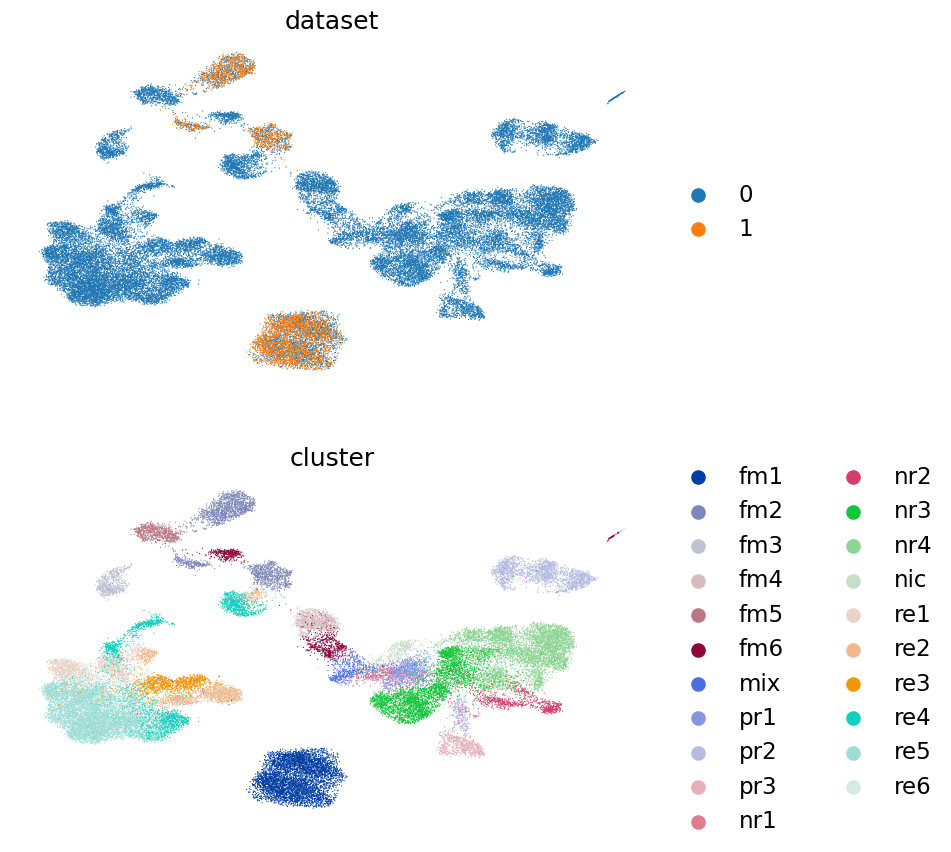

In [33]:
sc.pl.umap(
    adata_combined, color=['dataset', 'cluster'], wspace=0.4, frameon=False, ncols=1,show=False
)
#plt.savefig('./umapFibro.pdf',bbox_inches='tight')

[<Axes: title={'center': 'dataset'}, xlabel='UMAP1', ylabel='UMAP2'>,
 <Axes: title={'center': 'library'}, xlabel='UMAP1', ylabel='UMAP2'>]

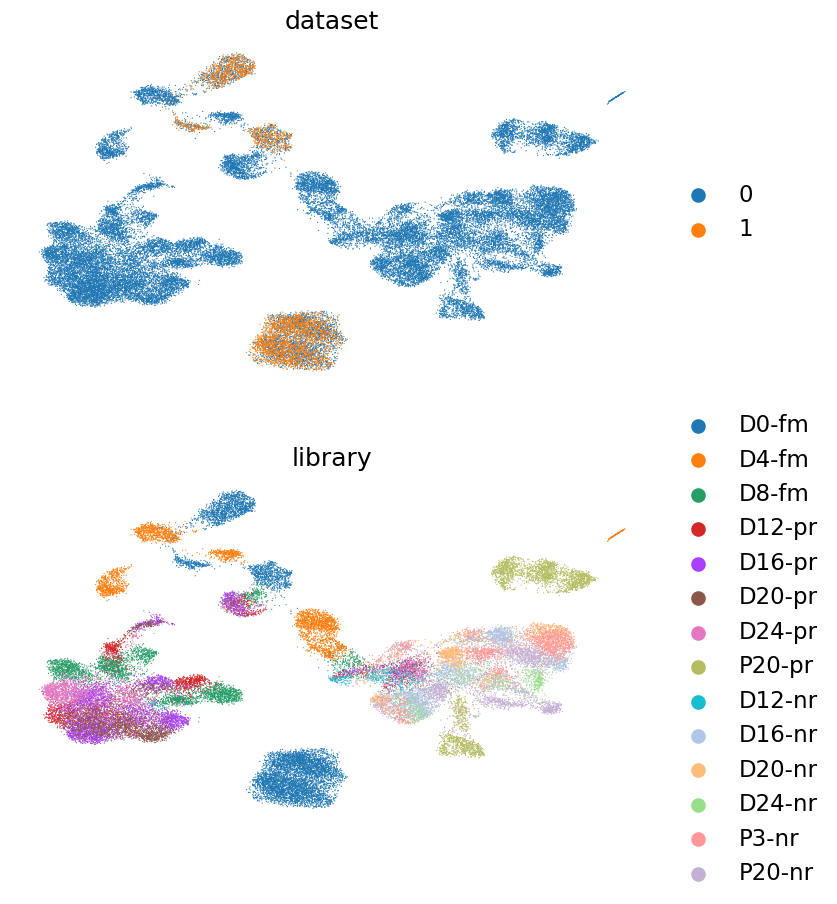

In [34]:
sc.pl.umap(
    adata_combined, color=['dataset', 'library'], wspace=0.4, frameon=False, ncols=1,show=False
)
#plt.savefig('./umapFibro.pdf',bbox_inches='tight')